In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import math
from qutip import destroy, expect, qeye, sigmaz, steadystate, tensor

In [3]:
def poisson(x, lam):
    return lam**x * np.exp(-lam) / math.factorial(x)

In [7]:
N = 10

a = tensor(destroy(N), qeye(2))
sigm = tensor(qeye(N), destroy(2))
sigz = tensor(qeye(N), sigmaz())

wc = 5
wa = 5
g = 0.5

kappa = 0.1
gamma = 0.1
dephasing = 500e-6
c_ops = [
    np.sqrt(kappa) * a,
    np.sqrt(gamma) * sigm,
    # np.sqrt(dephasing) * sigz,
]

def H(pump_freq, pump_power, blockade = False):
    h = (
        pump_power * (a + a.dag())
        + (wc - pump_freq) * a.dag() * a
    )
    if blockade:
        h += (
            + (wa - pump_freq) * sigm.dag() * sigm
            + g * (a.dag() * sigm + a * sigm.dag())
        )
    return h

In [9]:
pump_power = kappa * 0.5
h = H(wc - g, pump_power, True)

ss = steadystate(h, c_ops)
a_ss = expect(a, ss)
sigm_ss = expect(sigm, ss)

trial = ( -(1j*wc + kappa/2) * a_ss - 1j*pump_power ) /g

print(trial, sigm_ss)

(-2.721453880855839+0.9717244090247855j) (0.03175952231885171+0.26274573921852434j)


In [10]:
pump_power = kappa * 0.5

ex = ( (wa**2 + gamma**2/4)*(wc**2 + kappa**2/4) + g**2 * pump_power**2 ) / g**4
ex

10002.010100000001

In [11]:
pump_power * g * (wc*gamma/2 + wa*kappa/2)

0.0125

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_75864/73691540.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


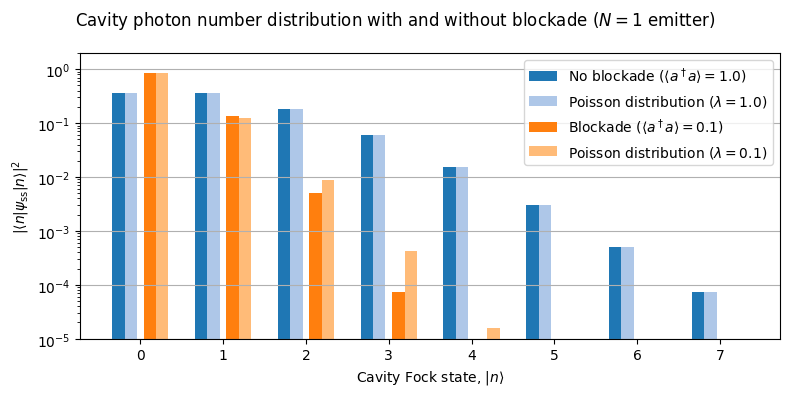

In [77]:
pump_power = kappa * 0.5

# no blockade case
h = H(wc, pump_power, blockade=False)
ss = steadystate(h, c_ops)
no_blockade_photon_numbers = ss.ptrace(0).diag() / sum(ss.ptrace(0).diag())
mean_no_blockade = expect(a.dag() * a, ss)

# blockade case
p = H(0, 0, True).eigenenergies()[1]
h = H(p, pump_power, blockade=True)
ss = steadystate(h, c_ops)
blockade_photon_numbers = ss.ptrace(0).diag() / sum(ss.ptrace(0).diag())
mean_blockade = expect(a.dag() * a, ss)

# poisson distribution
p_no_blockade = [poisson(i, mean_blockade) for i in range(N)]
p_blockade = [poisson(i, mean_no_blockade) for i in range(N)]

# bar chart of photon number distribution
idx = 8
x = np.arange(N)[:idx]
width = 0.15
offset = 0.04
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(x-1.5*width-offset, no_blockade_photon_numbers[:idx], width, label=f"No blockade ($\langle a^\dagger a\\rangle=${mean_no_blockade:.1f})", color='#1f77b4')
ax.bar(x-width/2-offset, p_blockade[:idx], width, label=f"Poisson distribution ($\lambda={mean_no_blockade:.1f}$)", color="#aec7e8")
ax.bar(x+width/2+offset, blockade_photon_numbers[:idx], width, label=f"Blockade ($\langle a^\dagger a\\rangle=${mean_blockade:.1f})", color="#ff7f0e")
ax.bar(x+1.5*width+offset, p_no_blockade[:idx], width, label=f"Poisson distribution ($\lambda={mean_blockade:.1f}$)", color="#ffbb78")
ax.set_xticks(x)
ax.set_yscale("log")
ax.set_ylim(1e-5, 2)
ax.legend()
ax.set_xlabel("Cavity Fock state, $|n\\rangle$")
ax.set_ylabel(r"$|\langle n| \psi_\text{ss} | n\rangle|^2$")
ax.yaxis.grid()

fig.suptitle("Cavity photon number distribution with and without blockade ($N=1$ emitter)")
fig.tight_layout()
fig.show()